Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#The state space is 1-dimensional.
N=100 #number of states.
A=2
q_low=0.51 #probability of success of action a_low, prob. of decreasing the size of the queue.
q_high=0.6 #probab ility of success of action a_high, prob. of decreasing the size of the queue.
p=0.5 #probability that the queue increases by 1.
actions=[0,1]
def reward(x,a):
    if a==1:
        return -(x/N)**2-0.01
    return -(x/N)**2

gamma=0.9

In [3]:
pi_lazy = np.zeros((N,2))
for x in range(N):
    pi_lazy[x,0]=1

pi_agg=np.zeros((N,2))
for x in range(N):
    if x<50:
        pi_agg[x,0]=1
    else:
        pi_agg[x,1]=1

In [4]:
r_lazy=np.zeros(N)
for x in range(N):
    r_lazy[x]=reward(x,0)

r_agg=np.zeros(N)
for x in range(N):
    if x<50:
        r_agg[x]=reward(x,0)
    else:
        r_agg[x]=reward(x,1)

Let us define the feature mappings functions.

In [5]:
def fine_map(x):
    function=np.zeros(N)
    function[int(x-1)]=1
    return function

def coarse_map(x):
    function=np.zeros(int(N/5))
    for i in range(len(function)):
        if 5*i<= x and x <= 5*(i+1)-1:
            function[i]=1
    return function

def piece_linear_map(x):
    function=np.zeros(int(2*N/5))
    for i in range(int(len(function)/2)):
        if 5*i<= x and x <= 5*(i+1)-1:
            function[i]=1
            break
    function[int(i+N/5)]=(x-5*i)/5
    return function

In [6]:
mapp_fine=np.zeros((N,N))
for x in range(N):
    mapp_fine[:,x]=fine_map(x)

mapp_coarse=np.zeros((int(N/5),N))
for x in range(N):
    mapp_coarse[:,x]=coarse_map(x)

mapp_piece=np.zeros((int(2*N/5),N))
for x in range(N):
    mapp_piece[:,x]=piece_linear_map(x)

TD(0)

In order to employ TD(0) we need to have samples of the type (X_t,A_t,R_t,X_t') representing transitions from state X_t to X_t', the action that was taken in that transition and the reward that was earned.

In [7]:
#We are going to build the transition matrix
#P[x,y,a] gives the probability of moving from state x to state y when taking action a.
#We will consider x-x_{t+1}; y-x_{t}; a, the action.
q_s=[q_low,q_high]
P = np.zeros((N,N,A))
for a in range(A):
    P[0,1,a]=p*(1-q_s[a])
    P[0,0,a]=p*q_s[a] + (1-p)*(1-q_s[a])+(1-p)*q_s[a]
    for x in range(1,N-1):
        P[x,x+1,a]=p*(1-q_s[a])
        P[x,x,a]=p*q_s[a] + (1-p)*(1-q_s[a])
        P[x,x-1,a]=(1-p)*q_s[a]
    P[N-1,N-1,a]=p*q_s[a] + (1-p)*(1-q_s[a])+p*(1-q_s[a])
    P[N-1,N-2,a]=(1-p)*q_s[a]

In [8]:
pi_lazy = np.zeros((N,2))
for x in range(N):
    pi_lazy[x,0]=1

pi_agg=np.zeros((N,2))
for x in range(N):
    if x<50:
        pi_agg[x,0]=1
    else:
        pi_agg[x,1]=1

In [9]:
#Calculation of the transition matrix for policy pi_lazy
def trans(P,pi): # constructs X by X transition matrix for policy pi_lazy
    X = np.size(P,0)
    P_pi = np.zeros((X,X))
    for x in range(X):
        for y in range(X):
            for a in range(2):
                P_pi[x,y]=P_pi[x,y]+pi[x,a]*P[x,y,a]

    return P_pi

In [10]:
P_lazy=trans(P,pi_lazy)
P_agg=trans(P,pi_agg)

In [11]:
def sample_generator(len_window,policy,transition):
    X=99
    samples=np.zeros((len_window,4))
    for i in range(len_window):
        samples[i][0]=X
        #print(np.argmax(policy[X,:]))
        samples[i][1]=q_s[np.argmax(policy[X,:])]
        samples[i][2]=reward(X,samples[i][1])#reward given to agent after executing the action a being in state X.
        fila=transition[X,:]#this line gives the probabilities of transition from the state x to every other state.
        next_state = np.random.choice(np.nonzero(fila)[0],p=fila[(np.nonzero(fila)[0])])
        X=next_state
        samples[i][3]=X
    return samples

def TD_0(gamma,samples,mapp):
    Value=np.zeros(N)
    theta=np.zeros(len(mapp[:,0]))
    for t in range(len(samples[:,1])):
        X=samples[t][0]
        delta=samples[t,2]+gamma*Value[int(samples[t][3])]-Value[int(X)]
        theta=theta+ 10**5/(10**5 + t)*delta*mapp[:,int(X)]
        np.dot(theta,mapp, out=Value)
    return Value

Vamos a definir antes las samples y así no tenemos que irlas generando durante el bucle de manera repetida

In [12]:
samples_lazy=[]
samples_agg=[]
sizes=[10**4,10**5,10**6,10**7]
transitions=[P_lazy,P_agg]
policies=[pi_lazy,pi_agg]
for i in range(4):
  samples_lazy.append(sample_generator(sizes[i],policies[0],transitions[0]))
for i in range(4):
  samples_agg.append(sample_generator(sizes[i],policies[1],transitions[1]))

CODE FOR THE GRAPHICS USING TD(0)

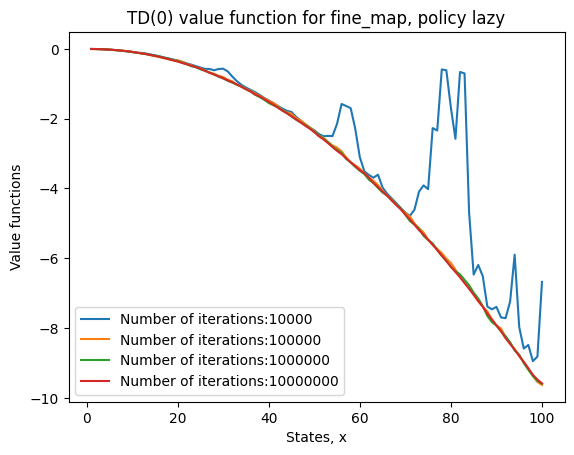

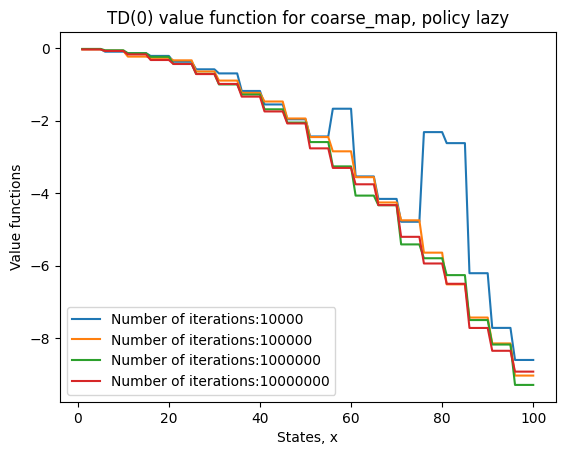

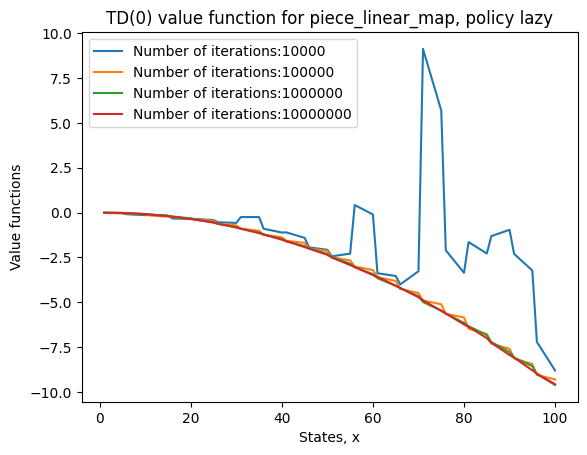

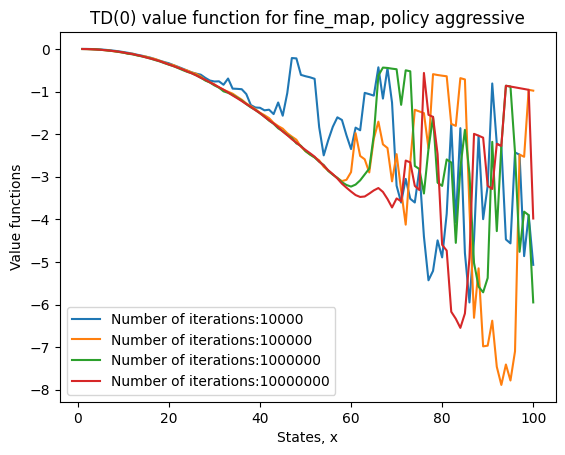

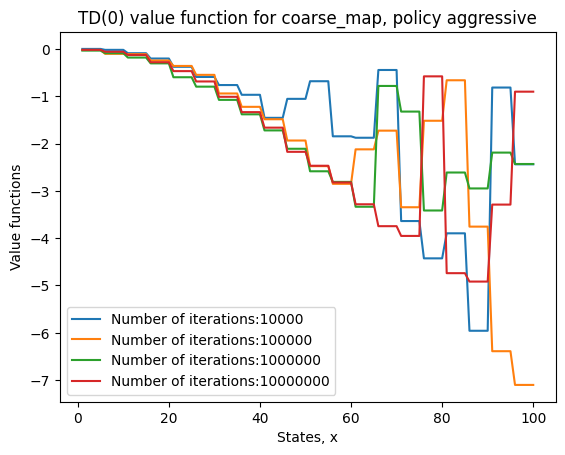

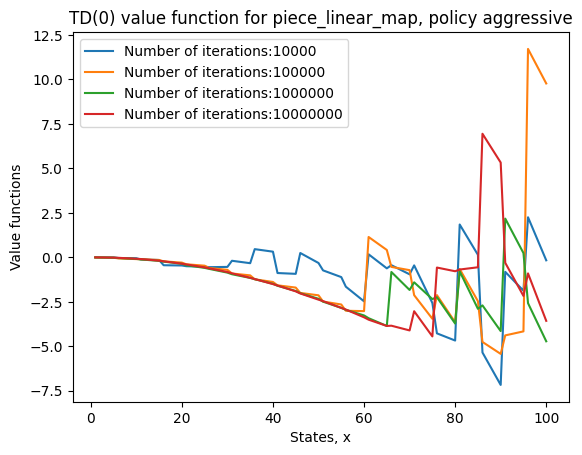

In [113]:
transitions=[P_lazy,P_agg]
policies=[pi_lazy,pi_agg]
labels=['lazy', 'aggressive']
functions=[mapp_fine,mapp_coarse,mapp_piece]
functions_label=['fine_map','coarse_map','piece_linear_map']
iterations=[10**4,10**5,10**6,10**7]
rewards=[r_lazy,r_agg]
eje_x=[i for i in range(1,N+1)]
for i in range(2):
    for j in range(3):
        plt.figure()
        plt.xlabel('States, x')
        plt.ylabel('Value functions')
        plt.title(f'TD(0) value function for {functions_label[j]}, policy {labels[i]}')
        if labels[i]=='lazy':
            for samples in samples_lazy:
                value=TD_0(0.9,samples,functions[j])
                plt.plot(eje_x,value,label=f'Number of iterations:{len(samples[:,0])}')
                plt.legend()
        else:
            for samples in samples_agg:
                value=TD_0(0.9,samples,functions[j])
                plt.plot(eje_x,value,label=f'Number of iterations:{len(samples[:,0])}')
                plt.legend()

Plot the resulting value functions and compare them to the results you have obtained in the first problem set.

From the graphics we can see that depending on the number of sample transitions and the functions employed to do the Linear Approximation the value functions result quite differenly. As we can see, as the number of transition samples increases, the convergence improves and the resultant value functions get closer to the value we came up with using the evaluation method of the previous homework.

It shows easily that 10**4 sample transitions is not enough to achieve a good approximation. This makes sense due to the fact that the samples are generated randomly according to the probability distribution that arises from the transition matrix for each policy, and hence the number of samples generated needs to be sufficiently high to manage a good probabilistic approximation of the transitions. 

According to the function used for the linear approximation, we can see that the fine map is the one that delivers the best similar, as for similarity to the value functions obtained in the previous homework. Regarding the coarse function, the fact that it is an indicator function over sets of 5 elements make it having the same value for all x in each set, so that's why the resulting value function has this stair-like appereance. Finally for the piecewise function we see that the value functions' noise increase in general, though for the high iterations the results, specially for lazy policy are close the ones we got in Homework 1.

In general, we observe that TD_0 with these functions approximates better for policy lazy, while for policy aggresive it does not approximate that well. The fact that policy lazy always has the same value might be the reason why it is easier for the method to converge, because it is monotonous. On the contrary, the fact that policy aggresive switches its values at x=50 might introduce some randomness in the method as the queue gets small. This makes it harder for it to converge, i.e., more samples are needed to make the method converge to the value function.

CODE FOR THE GRAPHICS THROUGH LSTD

In [13]:
def LSTD(mapp, samples):
    num_features = len(mapp)
    A = np.zeros((num_features, num_features))
    b = np.zeros(num_features)

    for t in range(len(samples)):
        phi_t = mapp[:, int(samples[t, 0])]
        phi_t_next = mapp[:, int(samples[t, 3])]
        reward_t = samples[t, 2]

        A += np.outer(phi_t, phi_t - gamma*phi_t_next)
        b += phi_t * reward_t
    theta = np.matmul(np.linalg.pinv(A/len(samples)), b/len(samples))

    Value = np.dot(theta, mapp)

    return Value

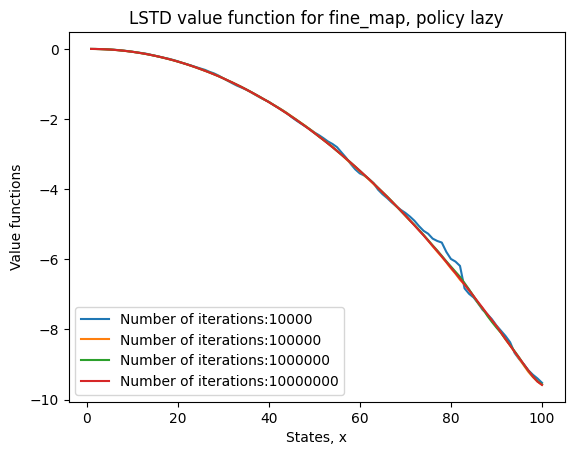

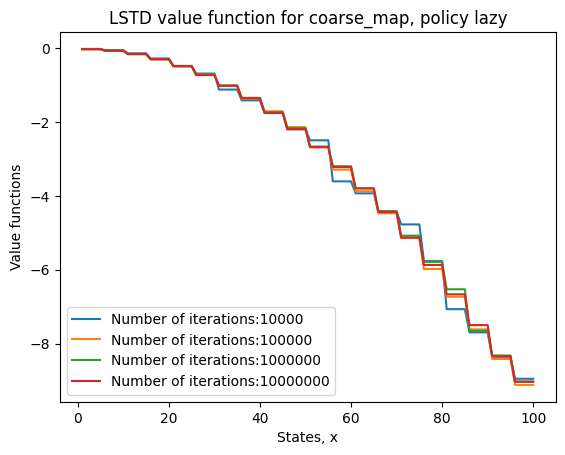

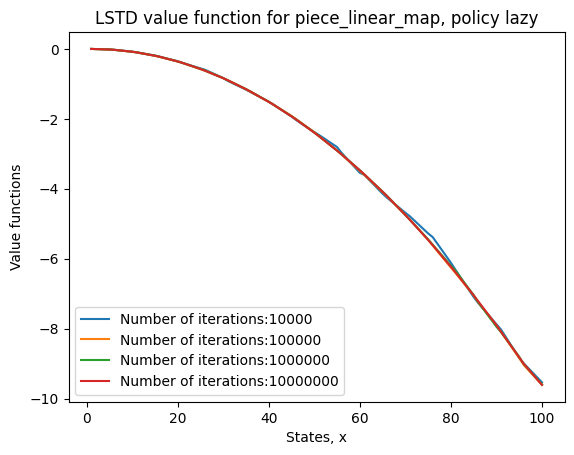

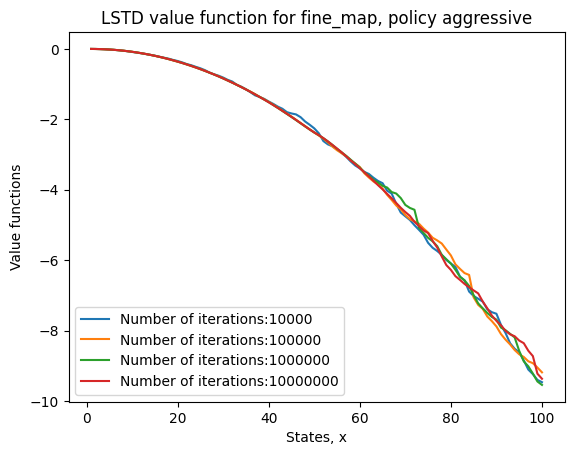

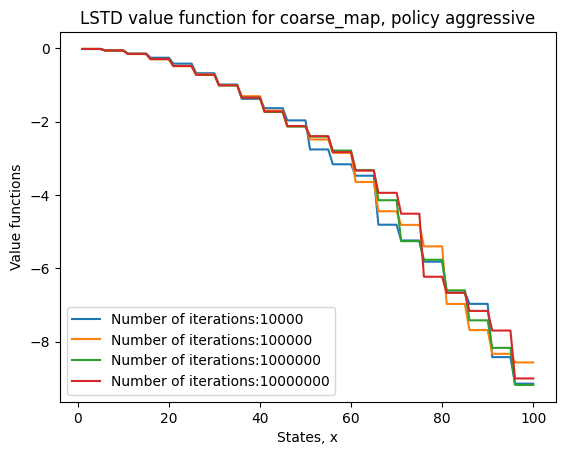

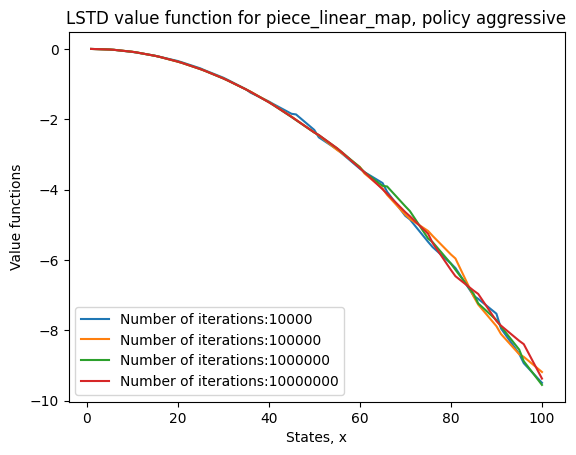

In [152]:
for i in range(2):
    for j in range(3):
        plt.figure()
        plt.xlabel('States, x')
        plt.ylabel('Value functions')
        plt.title(f'LSTD value function for {functions_label[j]}, policy {labels[i]}')
        if labels[i]=='lazy':
            for samples in samples_lazy:
                value=LSTD(functions[j],samples)
                plt.plot(eje_x,value,label=f'Number of iterations:{len(samples[:,0])}')
                plt.legend()
        else:
            for samples in samples_agg:
                value=LSTD(functions[j],samples)
                plt.plot(eje_x,value,label=f'Number of iterations:{len(samples[:,0])}')
                plt.legend()

For LSTD graphics, the comments made regarding iterations for TD_0 are still valid, i.e., the larger the number of iterations is, the better the approximation to the value function we computed in Homework 1 is. However, in LSTD the number of samples is not that crucial regarding convergence, as we see that the noise for low sample transitions numbers is very low when compared to the one we see in LSTD. Moreover, this method performs better for aggresive policy than TD_0. We still observe that the value function for coarse function is stairs-like, because this does not depend on the algorithm. However, for the piecewise function, the results are much better than TD_0, since the noise is drastically reduced for both lazy and aggresive policy. 

In general we can conclude that LSTD performs much better than TD_0, since not only it reduces the noise and uncertainty but also it converges faster, i.e., with a less number of samples. This can be associated to the fact that LSTD is not an iterative method in the sense that the value function is computed only once, after updating the A matrix and b vector. The value function is derived after solving a linear equations system, which may make the algorithm not so dependent on the number of sample transition and provide more stability to the resultant value functions.

Exercise 2

In [14]:
def Q(x,a,Value):
    if x==0:
        return reward(x,a)+ gamma*(1-p)*(1-q_s[a])*Value[int(x)]+gamma*p*(q_s[a]*Value[int(x)]+(1-q_s[a])*Value[int(x+1)])
    elif x==N-1:
        return reward(x,a) + gamma*(1-p)*(q_s[a]*Value[int(x-1)]+(1-q_s[a])*Value[int(x)])+gamma*p*q_s[a]*Value[int(x)]
    return reward(x,a) + gamma*(1-p)*(q_s[a]*Value[int(x-1)]+(1-q_s[a])*Value[int(x)])+gamma*p*(q_s[a]*Value[int(x)]+(1-q_s[a])*Value[int(x+1)])

In [15]:
def policy_aprox(max_iterations):
    pi=np.zeros((N,2))
    samples=samples_lazy[0]
    for i in range(max_iterations):
        value=LSTD(mapp_fine,samples)
        for x in range(N):
            valores=np.zeros(2)
            for a in actions:
                valores[a] = Q(x,a,value)
            pi[x,:]=0
            pi[x,actions[np.argmax(valores)]]=1
        transition=trans(P,pi)
        samples=sample_generator(10**4,pi,transition)
    return LSTD(mapp_fine,samples), pi

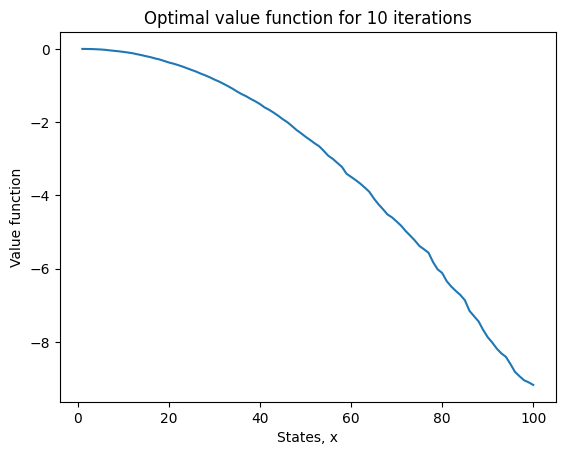

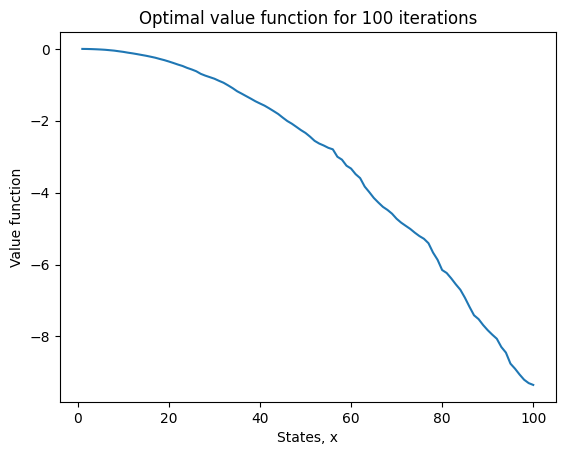

In [16]:
opt_policies=[]
value_optimals={}
for max_iter in [10,100]:
  value, pi=policy_aprox(max_iter)
  opt_policies.append(pi)
  value_optimals[max_iter]=value
  plt.figure()
  plt.plot(range(1,N+1),value)
  plt.xlabel('States, x')
  plt.ylabel('Value function')
  plt.title(f'Optimal value function for {max_iter} iterations')
        
  

As we can see, the optimal value functions calculated with the policy approximation method are quite similar to the ones obtained in the first homework.
When compared to the ones that we obtain in the previous exercise, for those whose noise is low, we see that they are also similar to the value function obtained here, with a range of values from 0 to around -10.

Let's calculate the lazy value function:

In [17]:
### policy evaluation subroutine
# either via power iteration or inverting the matrix (I - gamma P_pi)
def evaluate(P,pi,r,gamma):
    X = np.size(P,0)
    value = np.zeros((X))
    matriz= np.linalg.inv((np.eye(X)-gamma*trans(P,pi)))
    value=np.dot(matriz,r)
    
    ### YOUR CODE COMES HERE
    ### YOUR CODE ENDS HERE
    return value

Value_lazy=evaluate(P,pi_lazy,r_lazy,gamma)

Text(0.5, 1.0, 'Difference between 100 iterations optimal value and lazy')

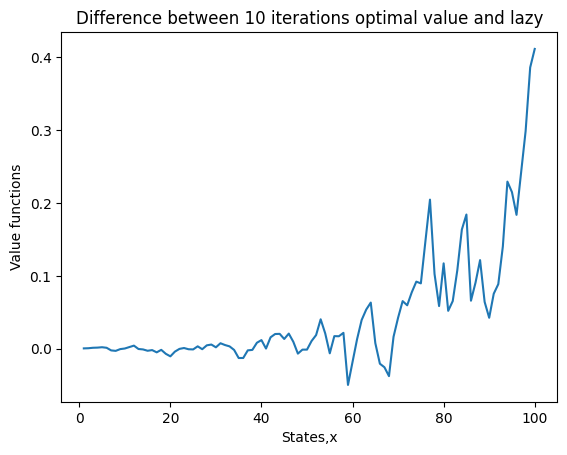

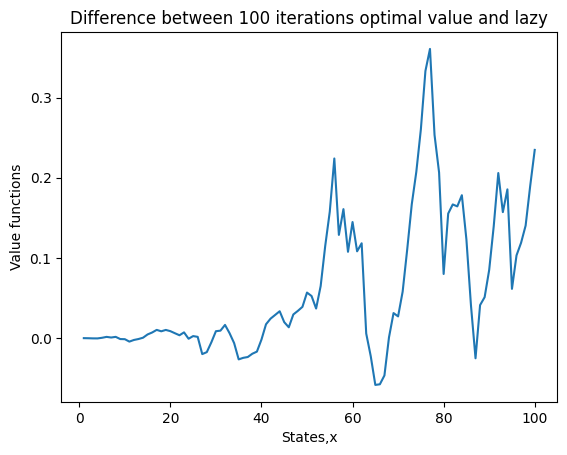

In [18]:
plt.figure()
plt.plot(range(1,N+1),value_optimals[10]-Value_lazy)
plt.xlabel('States,x')
plt.ylabel('Value functions')
plt.title('Difference between 10 iterations optimal value and lazy')

plt.figure()
plt.plot(range(1,N+1),value_optimals[100]-Value_lazy)
plt.xlabel('States,x')
plt.ylabel('Value functions')
plt.title('Difference between 100 iterations optimal value and lazy')



As we can see from the graphics where we have plotted the difference between the optimal value functions and the lazy value function, in both cases the optimal value function generally improves the lazy value function, though there are states where the lazy value function is bigger than the optimal ones. This can be associated to the fact that 10 or 100 iterations are not enough for the method to reach the optimal value function, or that the 10**5 samples transitions number is not enough to generate a good precise data distribution for the LSTD method, meaning that more samples are needed.

In [ ]:
#Let us now plot the q's associated with each action for each state x.

In [19]:
''' We calculate q(pi_k[x]) for each x with the following code, where the x element of each list is q_s evaluated in the index where the policy 
is 1 in state
'''
q_pi10=[q_s[np.where(opt_policies[0][x]==1)[0][0]] for x in range(N)]
q_pi100=[q_s[np.where(opt_policies[1][x]==1)[0][0]] for x in range(N)]

Text(0.5, 1.0, 'Cost of actions taken by optimal policy 100 iterations')

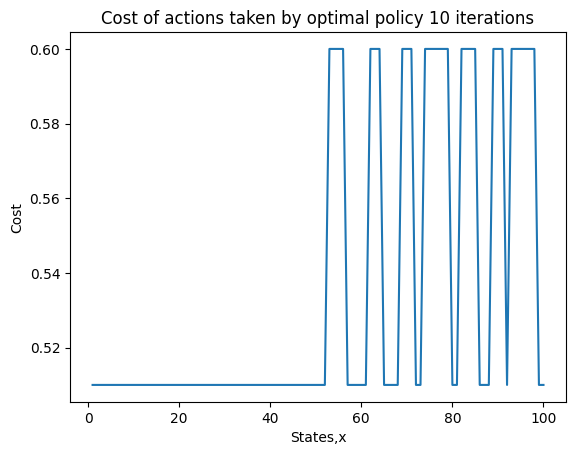

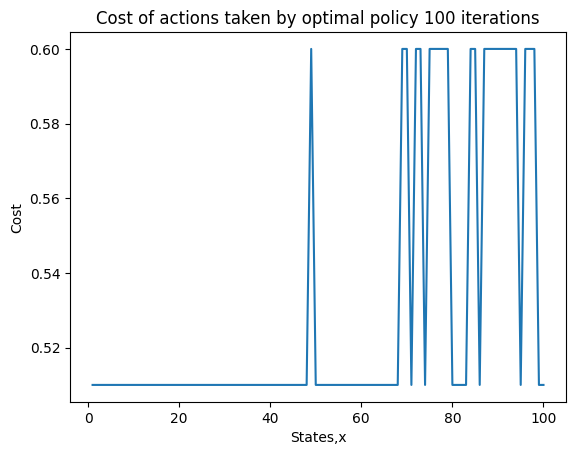

In [20]:
plt.plot(range(1,N+1),q_pi10)
plt.xlabel('States,x')
plt.ylabel('Cost')
plt.title('Cost of actions taken by optimal policy 10 iterations')

plt.figure()
plt.plot(range(1,N+1),q_pi100)
plt.xlabel('States,x')
plt.ylabel('Cost')
plt.title('Cost of actions taken by optimal policy 100 iterations')

As we saw in the homework 1 where the optimal value function would choose tha low action up to 62 and then switch to 63, we can say that both policies obtianed here are similar to that optimal policy, though still far from being the same. This may imply that the number of iterations chosen here or the number of samples transtions used in LSTD (10**5) are low to guarantee a good convergence.